# Explore the COCO dataset

## 1. Initialize coccoapi https://github.com/cocodataset/cocoapi

In [ ]:
import os
import sys
sys.path.append('/home/ubuntu/cocoapi/PythonAPI')
from pycocotools.coco import COCO

# initialize COCO API for instance annotations
dataDir = '/home/ubuntu/cocoapi/dataset/cocoapi'
dataType = 'val2014'
instances_annFile = os.path.join(dataDir, 'annotations/instances_{}.json'.format(dataType))
coco = COCO(instances_annFile)

# initialize COCO API for caption annotations
captions_annFile = os.path.join(dataDir, 'annotations/captions_{}.json'.format(dataType))
coco_caps = COCO(captions_annFile)

# get image ids 
ids = list(coco.anns.keys())

## 2. Plot a sample image

In [ ]:
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
%matplotlib inline

# pick a random image and obtain the corresponding URL
ann_id = np.random.choice(ids)
img_id = coco.anns[ann_id]['image_id']
img = coco.loadImgs(img_id)[0]
url = img['coco_url']

# print URL and visualize corresponding image
print(url)
I = io.imread(url)
plt.axis('off')
plt.imshow(I)
plt.show()

# load and display captions
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)

# Prepare the dataset

In [ ]:
!pip install nltk
!pip install tqdm
import nltk
nltk.download('punkt')
from data_loader import get_loader
from torchvision import transforms

# Define a transform to pre-process the training images.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Set the minimum word count threshold.
vocab_threshold = 5

# Specify the batch size.
batch_size = 10

# Obtain the data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         cocoapi_loc="/home/ubuntu/cocoapi/dataset",
                         vocab_from_file=True)

# Some NLP

In [ ]:
sample_caption = 'A person doing a trick on a rail while riding a skateboard.'

sample_tokens = nltk.tokenize.word_tokenize(str(sample_caption).lower())
print(sample_tokens)

In [ ]:
start_word = data_loader.dataset.vocab.start_word
end_word = data_loader.dataset.vocab.end_word


print('Special start word:', start_word)
print('Index in the vocab:', data_loader.dataset.vocab(start_word))
print('Special end word:', end_word)
print('Index in the vocab:', data_loader.dataset.vocab(end_word))

In [ ]:
full_caption = []

full_caption.append(data_loader.dataset.vocab(start_word))
full_caption.extend([data_loader.dataset.vocab(token) for token in sample_tokens])
full_caption.append(data_loader.dataset.vocab(end_word))

print('Full caption to feed to the network', full_caption)

In [ ]:
print('Total number of tokens in vocabulary:', len(data_loader.dataset.vocab))

In [ ]:
unk_word = data_loader.dataset.vocab.unk_word
print('Special unknown word:', unk_word)

print('All unknown words are mapped to this integer:', data_loader.dataset.vocab(unk_word))

In [ ]:
print(data_loader.dataset.vocab('jfkafejw'))
print(data_loader.dataset.vocab('ieowoqjf'))

# The models

# Training

### Hyper Parameters

In [ ]:
batch_size = 100          # batch size
vocab_threshold = 6        # minimum word count threshold
vocab_from_file = True    # if True, load existing vocab file
embed_size = 512           # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_epochs = 3             # number of training epochs
save_every = 1             # determines frequency of saving model weights
print_every = 100          # determines window for printing average loss
log_file = 'training_log.txt'       # name of file with saved training loss and perplexity

### Dataset

In [ ]:
from model import EncoderCNN, DecoderRNN

ransform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Build data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         cocoapi_loc="/home/ubuntu/cocoapi/dataset",
                         vocab_from_file=vocab_from_file)

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder. 
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

# Define the loss function. 
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# TODO #3: Specify the learnable parameters of the model.
params = list(decoder.parameters()) + list(encoder.embed.parameters()) 

# TODO #4: Define the optimizer.
optimizer = torch.optim.Adam(params)

# Set the total number of training steps per epoch.
total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)

### Train

In [ ]:
import torch.utils.data as data

# Open the training log file.
f = open(log_file, 'w')

old_time = time.time()
num_epochs = 1

for epoch in range(1, num_epochs+1):
    
    for i_step in range(1, total_step+1):
               
        # Randomly sample a caption length, and sample indices with that length.
        indices = data_loader.dataset.get_train_indices()
        
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader.batch_sampler.sampler = new_sampler
        
        # Obtain the batch.
        images, captions = next(iter(data_loader))

        # Move batch of images and captions to GPU if CUDA is available.
        images = images.to(device)
        captions = captions.to(device)
        
        # Zero the gradients.
        decoder.zero_grad()
        encoder.zero_grad()
        
        # Pass the inputs through the CNN-RNN model.
        features = encoder(images)
        outputs = decoder(features, captions)
        
        # Calculate the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
        
        # Backward pass.
        loss.backward()
        
        # Update the parameters in the optimizer.
        optimizer.step()
            
        # Get training statistics.
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), np.exp(loss.item()))
        
        # Print training statistics (on same line).
        print('\r' + stats, end="")
        sys.stdout.flush()
        
        # Print training statistics to file.
        f.write(stats + '\n')
        f.flush()
        
        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)
            
    # Save the weights.
    if epoch % save_every == 0:
        torch.save(decoder.state_dict(), os.path.join('./models', 'decoder-adam-%d.pkl' % epoch))
        torch.save(encoder.state_dict(), os.path.join('./models', 'encoder-adam-%d.pkl' % epoch))

# Close the training log file.
f.close()

# It will output something like this (take time)

```
Epoch [1/1], Step [100/4142], Loss: 2.1649, Perplexity: 8.7140
Epoch [1/1], Step [200/4142], Loss: 2.1569, Perplexity: 8.64417
Epoch [1/1], Step [300/4142], Loss: 2.0645, Perplexity: 7.88110
Epoch [1/1], Step [400/4142], Loss: 2.2012, Perplexity: 9.03592
Epoch [1/1], Step [500/4142], Loss: 2.1644, Perplexity: 8.70935
Epoch [1/1], Step [600/4142], Loss: 2.2433, Perplexity: 9.42430
Epoch [1/1], Step [700/4142], Loss: 2.0273, Perplexity: 7.59377
Epoch [1/1], Step [800/4142], Loss: 1.9731, Perplexity: 7.19303
Epoch [1/1], Step [900/4142], Loss: 2.1520, Perplexity: 8.60177
Epoch [1/1], Step [1000/4142], Loss: 2.0180, Perplexity: 7.5235
Epoch [1/1], Step [1100/4142], Loss: 2.2274, Perplexity: 9.27605
Epoch [1/1], Step [1200/4142], Loss: 2.1446, Perplexity: 8.53831
Epoch [1/1], Step [1300/4142], Loss: 2.1897, Perplexity: 8.93299
Epoch [1/1], Step [1400/4142], Loss: 2.7093, Perplexity: 15.0180
Epoch [1/1], Step [1500/4142], Loss: 2.0758, Perplexity: 7.97084
Epoch [1/1], Step [1600/4142], Loss: 1.9050, Perplexity: 6.71942
Epoch [1/1], Step [1700/4142], Loss: 2.0247, Perplexity: 7.57406
Epoch [1/1], Step [1800/4142], Loss: 2.0956, Perplexity: 8.13007
Epoch [1/1], Step [1900/4142], Loss: 1.9269, Perplexity: 6.86807
Epoch [1/1], Step [2000/4142], Loss: 2.0375, Perplexity: 7.67177
Epoch [1/1], Step [2100/4142], Loss: 2.2942, Perplexity: 9.91661
Epoch [1/1], Step [2200/4142], Loss: 1.8576, Perplexity: 6.40866
Epoch [1/1], Step [2300/4142], Loss: 2.1563, Perplexity: 8.63897
Epoch [1/1], Step [2400/4142], Loss: 2.3476, Perplexity: 10.4603
Epoch [1/1], Step [2500/4142], Loss: 2.1438, Perplexity: 8.53172
Epoch [1/1], Step [2600/4142], Loss: 2.3960, Perplexity: 10.9793
Epoch [1/1], Step [2700/4142], Loss: 2.0006, Perplexity: 7.39327
Epoch [1/1], Step [2800/4142], Loss: 2.0444, Perplexity: 7.72425
Epoch [1/1], Step [2900/4142], Loss: 2.0893, Perplexity: 8.07968
Epoch [1/1], Step [3000/4142], Loss: 2.2431, Perplexity: 9.42210
Epoch [1/1], Step [3100/4142], Loss: 1.9175, Perplexity: 6.80404
Epoch [1/1], Step [3200/4142], Loss: 2.1342, Perplexity: 8.45015
Epoch [1/1], Step [3300/4142], Loss: 2.0993, Perplexity: 8.16053
Epoch [1/1], Step [3400/4142], Loss: 1.9697, Perplexity: 7.16839
Epoch [1/1], Step [3500/4142], Loss: 1.9141, Perplexity: 6.78088
Epoch [1/1], Step [3600/4142], Loss: 1.9573, Perplexity: 7.08012
Epoch [1/1], Step [3700/4142], Loss: 1.8991, Perplexity: 6.67962
Epoch [1/1], Step [3800/4142], Loss: 1.9352, Perplexity: 6.92548
Epoch [1/1], Step [3900/4142], Loss: 2.0778, Perplexity: 7.98697
Epoch [1/1], Step [4000/4142], Loss: 2.1452, Perplexity: 8.54338
Epoch [1/1], Step [4100/4142], Loss: 2.0229, Perplexity: 7.56003
Epoch [1/1], Step [4142/4142], Loss: 2.1649, Perplexity: 8.71344
```

# Inference

## DataLoader for the test set

In [28]:
import os
import torch
from model import EncoderCNN, DecoderRNN
from data_loader import get_loader

# TODO #1: Define a transform to pre-process the testing images.
transform_test = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
#   We do not need flip when testing
#   transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])


#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Create the data loader.
data_loader = get_loader(transform=transform_test,
                         cocoapi_loc="/home/ubuntu/cocoapi/dataset",
                         mode='test')

Vocabulary successfully loaded from vocab.pkl file!


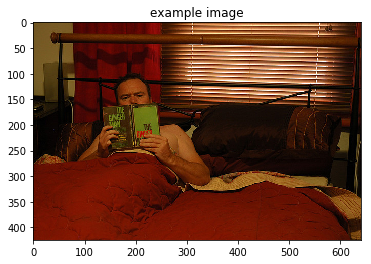

In [29]:
%matplotlib inline

# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Load the trained model

In [31]:
# TODO #2: Specify the saved models to load.
encoder_file = 'encoder-adam-1.pkl' 
decoder_file = 'decoder-adam-1.pkl'

# TODO #3: Select appropriate values for the Python variables below.
embed_size = 512
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

DecoderRNN(
  (embed): Embedding(8856, 512)
  (lstm): LSTM(512, 512, batch_first=True)
  (softmax): Softmax()
  (linear): Linear(in_features=512, out_features=8856, bias=True)
)

In [34]:
# TODO #4: Complete the function.
def clean_sentence(output):
    start_word = data_loader.dataset.vocab(data_loader.dataset.vocab.start_word)
    end_word = data_loader.dataset.vocab(data_loader.dataset.vocab.end_word)
    
    return ' '.join([data_loader.dataset.vocab.idx2word[x] for x in output if x != start_word and x != end_word])

def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

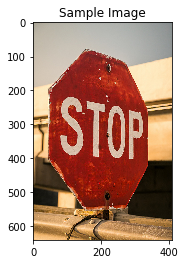

a red and white fire hydrant on a sidewalk .


In [42]:
get_prediction()

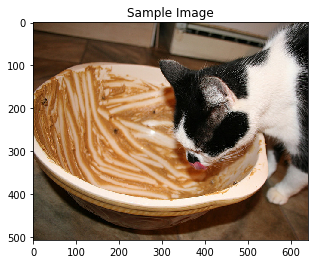

a cat is sitting on a toilet bowl .


In [43]:
get_prediction()